
---

# __REALISEZ UNE ANALYSE DE SENTIMENTS GRACE AU DEEP LEARNING__

---


## SOMMAIRE

- [ETAPE 0 : CADRAGE ET SETUP](#etape-0--cadrage-et-setup)

- [ETAPE 1 : DONNEES ET DICTIONNAIRE](#etape-1--donnees-et-dictionnaire)

- [ETAPE 2 : EXPLORATORY DATA ANALYSIS](#etape-2--exploratory-data-analysis)

- [ETAPE 3 : PRETRAITEMENT NLP](#etape-3--pretraitement-nlp)

- [ETAPE 4 : VECTORISATION](#etape-4--vectorisation)

- [ETAPE 5 : BASELINES SUPERVISEES CLASSIQUES](#etape-5--baselines-supervisees-classiques)




---

## __ETAPE 1 : DONNEES ET DICTIONNAIRE__

---

In [1]:
import sys
import os

# On ajoute le chemin absolu vers src/
sys.path.append(os.path.abspath(".."))

import mlflow
from src.utils.tracking import log_run


# On fixe l'emplacement centralisé des logs MLflow
project_root = os.path.abspath("..")  # on est dans notebooks/
mlflow.set_tracking_uri(f"file://{project_root}/mlruns")

# On déclare (ou crée si nécessaire) l'expérience
mlflow.set_experiment("Projet7-Sentiment")

# Stoppe un run bloqué d’une session précédente
if mlflow.active_run():
    mlflow.end_run()


# Exemple de paramètres et métriques fictifs
params = {"C": 1.0, "penalty": "l2"}
metrics = {"accuracy": 0.82, "f1": 0.79}

# Lancement d’un premier run de test
log_run("Test-LogisticRegression", params, metrics)



2025/09/15 15:30:50 INFO mlflow.tracking.fluent: Experiment with name 'Projet7-Sentiment' does not exist. Creating a new experiment.


In [2]:
# Chemin vers la racine du projet
project_root = os.path.abspath("..")

# Chemin vers le dossier data/processed
processed_dir = os.path.join(project_root, "data", "processed")

# Crée le dossier s’il n’existe pas
os.makedirs(processed_dir, exist_ok=True)


### __Documentation du jeu de données brut__

Le fichier brut `training.1600000.processed.noemoticon.csv` contient __6 colonnes__ :  

- __0 : sentiment__ — valeur binaire (`0 = négatif`, `4 = positif`)  
- __1 : id__ — identifiant unique du tweet  
- __2 : date/heure__ — horodatage de la publication  
- __3 : query__ — champ lié à la recherche (souvent `"NO_QUERY"`)  
- __4 : username__ — nom d’utilisateur Twitter  
- __5 : text__ — contenu textuel du tweet  

#### Pipeline appliqué pour générer les données traitées
- Lecture du CSV brut avec l’encodage `latin-1`  
- Sélection des colonnes __0__ et __5__ → renommage en `label` et `text`  
- Filtrage des lignes vides et normalisation minimale du texte  
- Sauvegarde du jeu de données nettoyé au format __parquet__ dans `data/processed/tweets.parquet`  

Ce pipeline permet de simplifier le dataset pour se concentrer uniquement sur les textes et leurs labels (positif/négatif).


In [3]:
import pandas as pd

# Chemins vers les fichiers
SOURCE_RAW = os.path.join(project_root, "data", "raw", "training.1600000.processed.noemoticon.csv")
SOURCE_PROCESSED = os.path.join(project_root, "data", "processed", "tweets.parquet")

print("Données brutes (non chargées ici) :", SOURCE_RAW)
print("Données traitées (chargées)       :", SOURCE_PROCESSED)


Données brutes (non chargées ici) : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/raw/training.1600000.processed.noemoticon.csv
Données traitées (chargées)       : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/tweets.parquet


In [4]:
# Charger le fichier parquet optimisé
df = pd.read_parquet(SOURCE_PROCESSED)

# Aperçu des données
df.head()


,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### __Dimensions du dataset__


In [5]:
df.shape


(1600000, 2)

### __Répartition des labels__


In [6]:
df['label'].value_counts(normalize=True)


label
0    0.5
4    0.5
Name: proportion, dtype: float64

### __Statistiques sur la longueur des tweets__


,count,mean,std,min,25%,50%,75%,max
len,1600000.00,74.09,36.44,6.00,44.00,69.00,104.00,374.00


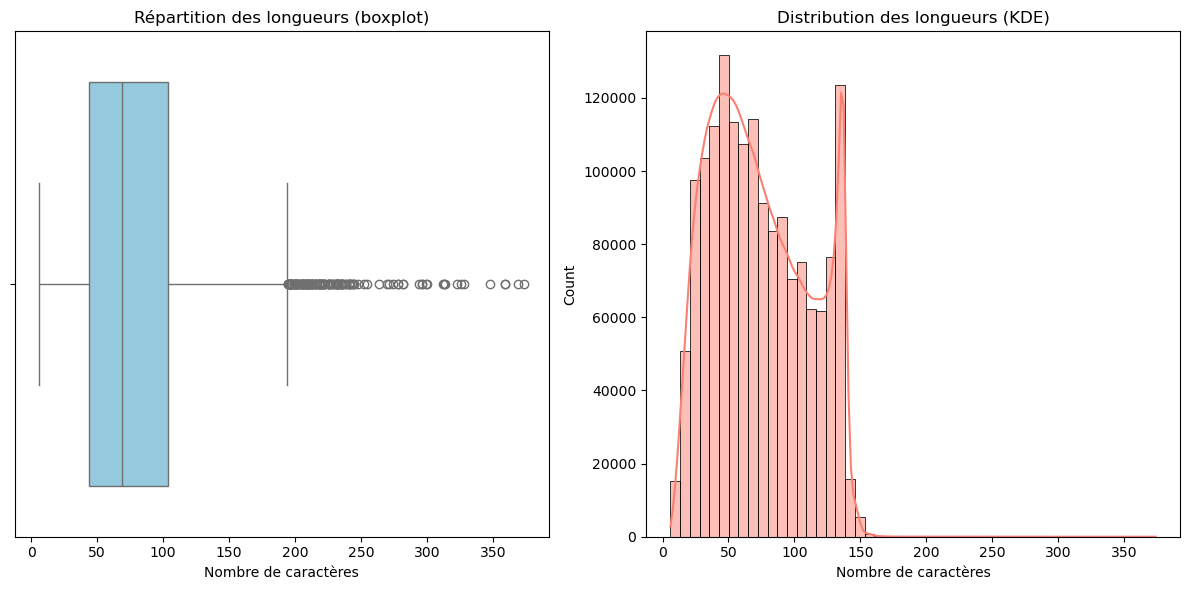

In [7]:
# Stats basiques sous forme de DataFrame stylé
df["len"] = df["text"].apply(len)
length_stats = df["len"].describe().to_frame().T
styled_table = length_stats.style.format(precision=2).set_caption("Statistiques descriptives des longueurs de tweets")
display(styled_table)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df["len"], color="skyblue")
plt.title("Répartition des longueurs (boxplot)")
plt.xlabel("Nombre de caractères")

# Distribution (KDE)
plt.subplot(1, 2, 2)
sns.histplot(df["len"], kde=True, bins=50, color="salmon")
plt.title("Distribution des longueurs (KDE)")
plt.xlabel("Nombre de caractères")

plt.tight_layout()
plt.show()


__Résumé des longueurs de tweets__ :

- Total de tweets : 1,6 million
- Longueur moyenne : ~74 caractères
- Médiane : 69 caractères
- Écart-type : 36 caractères
- 🔻 Min : 6 caractères | 🔺 Max : 374 caractères
- Quartiles : 
  - 25% < 44
  - 50% < 69
  - 75% < 104

__La majorité des tweets sont courts, avec une distribution modérément étalée.__


In [8]:
# Aperçu types et valeurs manquantes
display(df.dtypes)
display(df.isna().sum().sort_values(ascending=False))

# Vérification du domaine de labels
labels_uniques = sorted(df["label"].unique().tolist())
print("Labels uniques :", labels_uniques)
assert set(labels_uniques).issubset({0,4}), "Les labels ne sont pas uniquement {0,4}."

# Doublons (au cas où)
nb_dupl_text = df["text"].duplicated().sum()
print("Doublons sur 'text' :", nb_dupl_text)


label     int64
text     object
len       int64
dtype: object

label    0
text     0
len      0
dtype: int64

Labels uniques : [0, 4]
Doublons sur 'text' : 18534


### __Création d'un dictionnaire de données__

Un dictionnaire de données (ou data dictionary) est un document qui décrit chaque colonne du dataset.  
Il répond à trois objectifs :
- __Compréhension__ : savoir exactement ce que contient chaque champ (utile pour le créateur, mais aussi pour le lecteur).
- __Communication__ : toute personne peut reprendre le projet et comprendre la structure des données sans replonger dans le CSV.
- __Traçabilité__ : noter les décisions (par ex. « colonne X supprimée car redondante »).

In [9]:
import numpy as np

def safe_example(series, max_len=80):
    if series.empty:
        return ""
    x = series.iloc[0]
    if pd.isna(x):
        return ""
    x = str(x)
    return x[:max_len] + ("..." if len(x) > max_len else "")

# Métriques globales utiles
missing = df.isna().mean().to_dict()
nunique = df.nunique(dropna=True).to_dict()

# Dictionnaire de base
dico = []

# label
if "label" in df.columns:
    dico.append({
        "colonne": "label",
        "type": str(df["label"].dtype),
        "description": "Sentiment binaire (0 = négatif, 4 = positif)",
        "exemple": "" if df.empty else int(df["label"].iloc[0]),
        "%missing": round(100*missing.get("label", 0), 2),
        "n_uniques": int(nunique.get("label", 0))
    })

# text
if "text" in df.columns:
    dico.append({
        "colonne": "text",
        "type": str(df["text"].dtype),
        "description": "Contenu textuel du tweet (anglais)",
        "exemple": safe_example(df["text"]),
        "%missing": round(100*missing.get("text", 0), 2),
        "n_uniques": int(nunique.get("text", 0))
    })

# colonnes dérivées éventuelles
for c, desc in [
    ("len", "Longueur (nb de caractères) calculée"),
    # ("num_urls", "Nombre d'URL détectées"),
    # ("num_mentions", "Nombre de mentions détectées"),
]:
    if c in df.columns:
        dico.append({
            "colonne": c,
            "type": str(df[c].dtype),
            "description": desc,
            "exemple": "" if df.empty else df[c].iloc[0],
            "%missing": round(100*missing.get(c, 0), 2),
            "n_uniques": int(nunique.get(c, 0))
        })

# DataFrame propre avec colonnes ordonnées
cols_order = ["colonne", "type", "description", "exemple", "%missing", "n_uniques"]
data_dict = pd.DataFrame(dico)[cols_order]
display(data_dict)

# Exports
data_dict_path_csv = os.path.join(project_root, "reports", "data_dictionary.csv")
data_dict_path_md  = os.path.join(project_root, "reports", "data_dictionary.md")

data_dict.to_csv(data_dict_path_csv, index=False)

with open(data_dict_path_md, "w", encoding="utf-8") as f:
    f.write("# Data Dictionary\n\n")
    for _, r in data_dict.iterrows():
        f.write(f"## {r['colonne']}\n")
        f.write(f"- Type : `{r['type']}`\n")
        f.write(f"- Description : {r['description']}\n")
        f.write(f"- Exemple : {r['exemple']}\n")
        f.write(f"- % manquants : {r['%missing']}%\n")
        f.write(f"- Nb. valeurs uniques : {r['n_uniques']}\n\n")

print("Exporté :", data_dict_path_csv, "et", data_dict_path_md)


,colonne,type,description,exemple,%missing,n_uniques
0,label,int64,"Sentiment binaire (0 = négatif, 4 = positif)",0,0.0,2
1,text,object,Contenu textuel du tweet (anglais),"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0.0,1581466
2,len,int64,Longueur (nb de caractères) calculée,115,0.0,257


Exporté : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/data_dictionary.csv et /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/data_dictionary.md


### __Gestion des doublons__

Objectif : nettoyer les doublons avant l’EDA.
1) __Supprimer complètement__ les textes __contradictoires__ (même `text` avec des `label` différents).
2) Sur le reste, __garder la première occurrence__ pour chaque doublon __(même `text` et même `label`)__.

Cette décision vise à éviter d’introduire du bruit (contradictions) et à réduire les répétitions exactes qui n’apportent pas d’information supplémentaire au modèle.

In [10]:
# Nombre de doublons exacts sur la colonne text
nb_duplicated = df["text"].duplicated().sum()
print(f"Nombre de doublons détectés dans text : {nb_duplicated}")


Nombre de doublons détectés dans text : 18534


In [11]:
# Compter les occurrences par texte et garder ceux avec au moins 2 occurrences
dup_counts = (
    df.groupby("text", dropna=False)
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)

dup_counts_head = dup_counts[dup_counts["count"] > 1].head(20)
dup_counts_head


,text,count
1416158,isPlayer Has Died! Sorry,210
1312365,good morning,118
1333240,headache,115
843182,Good morning,112
870665,Headache,106
3166,"cant afford to see Angels and Demons, so i wa...",86
1069563,"Not to worry, noone got that one. Next questio...",86
847272,Goodnight,85
1462471,my tummy hurts,81
993586,"Jogging, isnt REALLY that cool, especially if ...",80


In [12]:
# Textes qui apparaissent avec plusieurs labels (incohérences)
multi_label = (
    df.groupby("text")["label"]
      .nunique()
      .reset_index(name="n_labels")
      .query("n_labels > 1")
)

print(f"Textes avec labels contradictoires : {len(multi_label)}")

# Voir quelques exemples contradictoires
if len(multi_label) > 0:
    sample_contra = (
        df.merge(multi_label[["text"]], on="text", how="inner")
          .sort_values("text")
          .head(50)
    )
    sample_contra


Textes avec labels contradictoires : 2225


In [13]:
# ---- paramètres de sortie
OUT_PATH = os.path.join(project_root, "data", "processed", "tweets_clean.parquet")  # nouveau fichier traité

# ---- 0) sauvegarder la taille initiale
n0 = df.shape[0]

# ---- 1) détecter les textes contradictoires (même text, plusieurs labels)
multi_label = (
    df.groupby("text")["label"]
      .nunique(dropna=False)
      .reset_index(name="n_labels")
      .query("n_labels > 1")
)

n_contra_texts = multi_label.shape[0]

# Vérification :
EXPECTED_CONTRADICTORY = 2225
print(f"Textes contradictoires détectés : {n_contra_texts}")
if EXPECTED_CONTRADICTORY and n_contra_texts != EXPECTED_CONTRADICTORY:
    print(f"⚠️ Note : tu attendais {EXPECTED_CONTRADICTORY}, on a trouvé {n_contra_texts}. (info, pas bloquant)")

# ---- 2) supprimer TOUTES les lignes dont le 'text' fait partie des contradictoires
df_no_contra = df[~df["text"].isin(multi_label["text"])].copy()
n_after_contra = df_no_contra.shape[0]
removed_contra_rows = n0 - n_after_contra

print(f"Lignes supprimées car 'text' contradictoire : {removed_contra_rows} (sur {n0})")
print(f"Taille après suppression des contradictoires : {df_no_contra.shape}")

# ---- 3) supprimer ensuite les doublons exacts (même text ET même label), garder la première occurrence
df_clean = df_no_contra.drop_duplicates(subset=["text", "label"], keep="first").copy()
n_final = df_clean.shape[0]
removed_exact_dups = n_after_contra - n_final
pct_reduc_total = 100 * (1 - n_final / n0)

print(f"Doublons exacts (text+label) supprimés : {removed_exact_dups}")
print(f"Taille finale : {df_clean.shape}  |  Réduction totale : {pct_reduc_total:.2f}%")

# ---- 4) enregistrer la version nettoyée
df_clean.to_parquet(OUT_PATH, index=False)
print(f"Export parquet : {OUT_PATH}")


Textes contradictoires détectés : 2225
Lignes supprimées car 'text' contradictoire : 6895 (sur 1600000)
Taille après suppression des contradictoires : (1593105, 3)
Doublons exacts (text+label) supprimés : 13864
Taille finale : (1579241, 3)  |  Réduction totale : 1.30%
Export parquet : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/tweets_clean.parquet


In [14]:
# Logger les décisions dans MLflow
metrics = {
    "n_rows_initial": int(n0),
    "n_texts_contradictoires": int(n_contra_texts),
    "n_rows_apres_contra": int(n_after_contra),
    "n_rows_final": int(n_final),
    "n_rows_removed_contra": int(removed_contra_rows),
    "n_rows_removed_exact_dups": int(removed_exact_dups),
    "pct_reduction_total": float(pct_reduc_total),
}
params = {
    "rule_contradictions": "drop ALL rows for texts with multiple labels",
    "rule_exact_duplicates": "drop_duplicates(subset=['text','label'], keep='first')",
    "output_path": OUT_PATH,
}

log_run("CLEAN_DUPLICATES_STEP1", params=params, metrics=metrics)
print("MLflow: décision de déduplication loggée.")


MLflow: décision de déduplication loggée.



---

## __ETAPE 2 : EXPLORATORY DATA ANALYSIS__

---

In [15]:
# Exploration des données texte
# Import des bibliothèques nécessaires
import seaborn as sns
import nltk
import spacy
import matplotlib.pyplot as plt
import tensorflow as tf


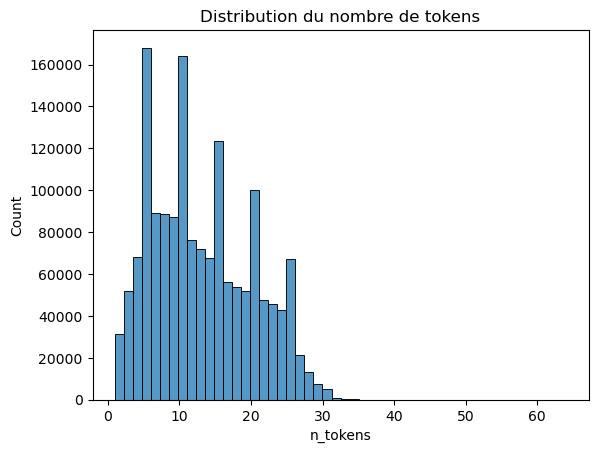

has_url        0.043864
has_mention    0.466520
has_hashtag    0.023008
dtype: float64

--- Exemples négatifs ---
["@xnausikaax oh no! where did u order from? that's horrible ", 'A great hard training weekend is over.  a couple days of rest and lets do it again!  Lots of computer time to put in now ', "Right, off to work  Only 5 hours to go until I'm free xD", 'I am craving for japanese food ', 'Jean Michel Jarre concert tomorrow  gotta work 7-3 before though ']

--- Exemples positifs ---
['Is lookin 4ward to a long weekend  really dont want to go to work 2day tho =[ x', '#myweakness  Is music and i live to meet the people who make it ', 'figured out the Internet on my new iPod ', "@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun ", "@sillybeggar Congrats James !! I'm sure the book is going to be a huge success "]


In [16]:
# Étape 2 : Exploration des données texte ---

# 1. Nb de tokens
df["n_tokens"] = df["text"].str.split().apply(len)
sns.histplot(df["n_tokens"], bins=50, kde=False)
plt.title("Distribution du nombre de tokens")
plt.show()

# 2. Analyse simple sur ponctuation/URLs/mentions
df["has_url"] = df["text"].str.contains("http")
df["has_mention"] = df["text"].str.contains("@")
df["has_hashtag"] = df["text"].str.contains("#")

print(df[["has_url", "has_mention", "has_hashtag"]].mean())

# 3. Quelques exemples de tweets
print("\n--- Exemples négatifs ---")
print(df[df["label"] == 0]["text"].sample(5, random_state=42).to_list())

print("\n--- Exemples positifs ---")
print(df[df["label"] == 4]["text"].sample(5, random_state=42).to_list())


__Vérifications des données__

Nous partons donc d'un Dataset parfaitement équilibré.

- Features ajoutées :
    - `has_url` : ≈ 4.4% des tweets contiennent un lien
    - `has_mention` : ≈ 46.6% des tweets mentionnent quelqu’un
    - `has_hashtag` : ≈ 2.3% des tweets contiennent un hashtag

- Visualisations :
    - Histogrammes et barplots ont bien fonctionné (les Figure size 640x480 confirment l’affichage des graphes).
    - Répartition équilibrée entre labels, distribution de longueurs de textes et fréquence des features.

- Exemples :
    - Négatifs → contiennent frustration, contraintes, et des sentiments partagés.
    - Positifs → anticipation, joie, succès, encouragement et sentiments partagés.
→ Sélection plutôt cohérente avec le label.

### __Sous-échantillon pour prototypage__
- Objectif : accélérer l’itération (prétraitement + baselines) sans saturer la machine.
- Méthode : échantillon stratifié __16 000 tweets__ (8 000 négatifs, 8 000 positifs) depuis le dataset nettoyé des doublons.
- Fichiers :
  - Entrée : `data/processed/tweets_clean.parquet`
  - Sortie : `data/processed/tweets_16k.parquet`
- Le jeu complet restera utilisé plus tard (optimisation et modèles avancés).



In [17]:
from pathlib import Path

IN_PATH  = os.path.join(project_root, "data", "processed", "tweets_clean.parquet")
OUT_PATH = os.path.join(project_root, "data", "processed", "tweets_16k.parquet")
SEED     = 42
N_PER_LABEL = 8000  # 8k par classe → 16k total

df_full = pd.read_parquet(IN_PATH)

# vérif classes
display(df_full["label"].value_counts())

# stratification simple : même nombre par classe
df_16k = (
    df_full
    .groupby("label", group_keys=False)
    .apply(lambda g: g.sample(n=N_PER_LABEL, random_state=SEED))
    .reset_index(drop=True)
)

display(df_16k.shape, df_16k["label"].value_counts())

# sauvegarde
Path("../data/processed").mkdir(parents=True, exist_ok=True)
df_16k.to_parquet(OUT_PATH, index=False)
print("Export échantillon :", OUT_PATH)


label
4    791281
0    787960
Name: count, dtype: int64

/var/folders/zt/cgsq3wl14cz2fvg9pccn_g1r0000gn/T/ipykernel_95293/4137985543.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=N_PER_LABEL, random_state=SEED))


(16000, 3)

label
0    8000
4    8000
Name: count, dtype: int64

Export échantillon : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/tweets_16k.parquet



---

## __ETAPE 3 : PRETRAITEMENT NLP__
## _sur l’échantillon 16k_

---

- Entrée : `data/processed/tweets_16k.parquet` (8k négatifs, 8k positifs).
- Étapes :
  1) Nettoyage (lower, URLs, @, #, HTML, non-alpha).
  2) Vérification de présence d'emojis et nettoyage si nécessaire.
  3) __Tokenisation__ + retraits de stopwords (→ `tokens`).
  4) __Lemmatisation__ spaCy (→ `lemmas`).
  5) __Stemming__ : via `SnowballStemmer` (NLTK).
  6) Texte final pour vectorisation (→ `text_clean`).
- Sortie : `data/processed/tweets_16k_clean_lem.parquet` et `data/processed/tweets_16k_clean_stem.parquet`.

__Décisions__ :
- Conserver la __négation__ (`not`, `no`, `nor`, `n't`) car signal fort pour le sentiment.
- Gérer les __contractions__ (don't → do not) avant tokenisation pour stabiliser les bigrammes (_not good_).
- Limiter les __allongements__ (soooo → soo) pour réduire le bruit.
- Supprimer l'éventuelle présence d'__emojis__.
- Mettre dans un __transformer sklearn__ réutilisable pour `Pipeline`/`GridSearchCV`.

Colonnes conservées à des fins pédagogiques :
- `text_clean_base`, `tokens`, `lemmas`, `text_clean`.


In [18]:
# 1. Imports et ressources nécessaires

import re
from typing import List
import emoji


# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# spaCy
import spacy

# Téléchargement des ressources si nécessaire
nltk.download('stopwords')
nltk.download('punkt')
stop_en = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Charge le modèle spaCy sans les entités ni la dépendance syntaxique
try:
    nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
except OSError:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/michele/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# 2. Charger l'échantillon de tweets

file_path = os.path.join(project_root, "data", "processed", "tweets_16k.parquet")
df = pd.read_parquet(file_path)
print("Shape:", df.shape)
print(df["label"].value_counts())


Shape: (16000, 3)
label
0    8000
4    8000
Name: count, dtype: int64


In [20]:
# 3. Règles de nettoyage et ressources

# Stopwords EN, mais conserver la négation (signal de sentiment)
neg_keep = {"not", "no", "nor", "n't"}
stop_en = {w for w in set(stopwords.words('english')) if w not in neg_keep}

# Contractions les plus courantes
CONTRACTIONS = {
    "won't": "will not", "can't": "can not", "ain't": "is not",
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "shouldn't": "should not", "wouldn't": "would not", "couldn't": "could not",
    "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
    "mustn't": "must not", "needn't": "need not",
    "n't": " not"   # fallback
}

def expand_contractions(text: str) -> str:
    t = text
    for c, rep in CONTRACTIONS.items():
        t = re.sub(rf"\b{re.escape(c)}\b", rep, t)
    return t

# Regex
URL_RE      = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE  = re.compile(r"@\w+")
HASHTAG_RE  = re.compile(r"#\w+")
HTML_RE     = re.compile(r"&\w+;")
# garder ":" et "_" pour :slightly_smiling_face:
NONALPHA_RE = re.compile(r"[^a-zA-Z\s:_]")
WS_RE       = re.compile(r"\s+")
REPEAT_RE   = re.compile(r"(.)\1{2,}")  # aaaa -> aa


In [21]:
# 4. Fonctions de nettoyage et tokenisation

def clean_basic(text: str) -> str:
    """Nettoyage : normalisation, emojis (optionnel), lower, contractions,
       URLs/@/#/HTML, répétitions, keep alpha/:/_ , trim."""
    if not isinstance(text, str):
        return ""
    t = unicodedata.normalize("NFKC", text)
    t = t.lower()
    t = expand_contractions(t)
    t = URL_RE.sub(" ", t)
    t = MENTION_RE.sub(" ", t)
    t = HASHTAG_RE.sub(" ", t)
    t = HTML_RE.sub(" ", t)
    t = REPEAT_RE.sub(r"\1\1", t)
    t = NONALPHA_RE.sub(" ", t)
    t = WS_RE.sub(" ", t).strip()
    return t

def tokenize_and_filter(text: str) -> List[str]:
    """Split simple + stopwords (en gardant la négation) + longueur min 3."""
    toks = text.split()
    toks = [w for w in toks if (len(w) >= 3) and (w in neg_keep or w not in stop_en)]
    return toks

def stem_tokens(tokens: list[str]) -> list[str]:
    return [stemmer.stem(t) for t in tokens]

In [22]:
# 5. Identification d'éventuels emojis

import emoji

df["has_emoji"] = df["text"].apply(lambda x: any(char in emoji.EMOJI_DATA for char in x))
df["has_emoji"].value_counts()


has_emoji
False    15988
True        12
Name: count, dtype: int64

In [23]:
# Retrait des tweets avec emojis
df = df[~df["text"].apply(lambda x: any(c in emoji.EMOJI_DATA for c in x))]
print("Shape après retrait tweets avec emojis :", df.shape)

Shape après retrait tweets avec emojis : (15988, 4)


In [24]:
df["label"].value_counts()

label
0    7997
4    7991
Name: count, dtype: int64

In [25]:
# 6. Rééquilibrage de l'échantillon
# Identifier le plus petit effectif
min_count = df["label"].value_counts().min()

# Sous-échantillonnage équilibré
df_balanced = df.groupby("label", group_keys=False).sample(n=min_count, random_state=42)

# Vérification
print(df_balanced["label"].value_counts())

# Sauvegarde
df_balanced.to_parquet(os.path.join(project_root, "data", "processed", "tweets_balanced.parquet"), index=False)

label
0    7991
4    7991
Name: count, dtype: int64


In [26]:
# 7. Pipeline pédagogique de nettoyage
# 6 étapes : nettoyage de base, tokenisation, stemmerisation, lemmatisation, textes finaux, sanity check

import unicodedata

# 1 Nettoyage base
df_balanced["text_clean_base"] = df_balanced["text"].apply(lambda t: clean_basic(t,))

# 2 Tokenisation
df_balanced["tokens"] = df_balanced["text_clean_base"].apply(tokenize_and_filter)

# 3 Stemmerisation
df_balanced["stems"] = df_balanced["tokens"].apply(stem_tokens)

# 4 Lemmatisation accélérée via nlp.pipe (OFF/ON emoji)
def lemmatize_series(list_of_tokens: pd.Series, n_process=4, batch_size=1000) -> List[List[str]]:
    texts = list_of_tokens.apply(lambda xs: " ".join(xs)).tolist()
    out = []
    for doc in nlp.pipe(texts, n_process=n_process, batch_size=batch_size):
        out.append([t.lemma_ for t in doc
                    if t.is_alpha and (t.text in neg_keep or (not t.is_stop and len(t.lemma_)>=3))])
    return out

df_balanced["lemmas"] = lemmatize_series(df_balanced["tokens"])

# 5 Textes finaux
df_balanced["text_clean_lem"] = df_balanced["lemmas"].apply(lambda xs: " ".join(xs))
df_balanced["text_clean_stem"] = df_balanced["stems"].apply(lambda tokens: " ".join(tokens))

# 6 Sanity check
assert len(df_balanced) == len(df_balanced["text_clean_lem"]), "Problème : longueurs différentes !"
display(df_balanced[["text", "text_clean_base", "tokens", "lemmas", "text_clean_lem", "text_clean_stem"]]
        .sample(5, random_state=42))


,text,text_clean_base,tokens,lemmas,text_clean_lem,text_clean_stem
4405,I miss honor soceity,i miss honor soceity,"[miss, honor, soceity]","[miss, honor, soceity]",miss honor soceity,miss honor soceiti
10590,@charm_next_door goodnight!,goodnight,[goodnight],[goodnight],goodnight,goodnight
14423,@jackiechanfs then I would pick rushhour 1 and...,then i would pick rushhour and shanghai knight...,"[would, pick, rushhour, shanghai, knights, end...","[pick, rushhour, shanghai, knight, end, rushho...",pick rushhour shanghai knight end rushhour win...,would pick rushhour shanghai knight end rushho...
8278,Tiiiiiired but FUN night. Remember now why Mik...,tiired but fun night remember now why mike was...,"[tiired, fun, night, remember, mike, good, fri...","[tiire, fun, night, remember, mike, good, frie...",tiire fun night remember mike good friend coll...,tiir fun night rememb mike good friend colleg ...
1165,hugging my pillow on a cold rainy night... boo...,hugging my pillow on a cold rainy night boo is...,"[hugging, pillow, cold, rainy, night, boo, bat...","[hug, pillow, cold, rainy, night, boo, batcave]",hug pillow cold rainy night boo batcave,hug pillow cold raini night boo batcav


In [27]:
# 8. Export des données

# 1) Version full clean + lemmatisation
df_lem = df_balanced[["text_clean_lem", "label"]].copy()
df_lem.rename(columns={"text_clean_lem": "text"}, inplace=True)
df_lem.to_parquet(os.path.join(project_root, "data", "processed", "tweets_16k_clean_lem.parquet"), index=False)

# 2) Version full clean + stemming
df_stem = df_balanced[["text_clean_stem", "label"]].copy()
df_stem.rename(columns={"text_clean_stem": "text"}, inplace=True)
df_stem.to_parquet(os.path.join(project_root, "data", "processed", "tweets_16k_clean_stem.parquet"), index=False)

# 3) Version texte brut
df_raw = pd.read_parquet(os.path.join(project_root, "data", "processed", "tweets_balanced.parquet"))
df_raw.to_parquet(os.path.join(project_root, "data", "processed", "tweets_16k_raw.parquet"), index=False)

df_raw = df_balanced[["text_clean_base", "label"]].copy()
df_raw.rename(columns={"text_clean_base": "text"}, inplace=True)
df_raw.to_parquet(os.path.join(project_root, "data", "processed", "tweets_16k_raw.parquet"), index=False)

print("3 versions nettoyées sauvegardées dans data/processed/")



3 versions nettoyées sauvegardées dans data/processed/


In [28]:
# 9. Log des résultats dans MLflow

mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Projet7-Sentiment")

with mlflow.start_run(run_name="PREPROCESS_16K_CLEANED", description="3 nettoyages : lem, stem, raw"):

    # --- Params ---
    mlflow.log_params({
        "keep_negation": "True",
        "contractions": "expanded",
        "repeat_norm": "≤2",
        "min_token_len": 3,
        "lemmatizer": "spaCy pipe",
        "stemmer": "SnowballStemmer",
        "output_formats": "parquet"
    })

    # --- Metrics ---
    mlflow.log_metrics({
        "n_rows": int(df_balanced.shape[0]),
        "avg_tokens_base": float(df_balanced["tokens"].apply(len).mean()),
        "avg_lemmas_base": float(df_balanced["lemmas"].apply(len).mean()),
        "avg_stems_base": float(df_balanced["stems"].apply(len).mean()),
    })

    # --- Artifacts (fichiers exportés) ---
    for filename in [
        "tweets_16k_clean_lem.parquet",
        "tweets_16k_clean_stem.parquet",
        "tweets_16k_raw.parquet"
    ]:
        path = os.path.join(project_root, "data", "processed", filename)
        mlflow.log_artifact(path)

print("MLflow : PREPROCESS_16K_CLEANED loggé.")



MLflow : PREPROCESS_16K_CLEANED loggé.


__Ce que cette structuration garantit__ :
- Montre clairement les différences de traitement.
- Donne une vision pédagogique complète du pipeline NLP appliqué aux données sociales.
- Produit deux sorties propres (`text_clean_lem` et `text_clean_stem`) et une sortie non nettoyée.
- Chaque étape est traçable et réplicable.
- La variable `text_final` est prête pour la vectorisation (Étape 4).

__Les traitements effectués__ :
- _Nettoyage_ : suppression des URLs, mentions, hashtags, ponctuations, seppression des 12 lignes contenant des emojis.
- _Normalisation_ : conversion en minuscules, nettoyage unicode, réduction des répétitions.
- _Tokenisation_ : découpe en mots, filtrage des `stopwords` et tokens < 3 caractères.
- _Stemming_ : via `SnowballStemmer` (NLTK) pour produire `text_clean_stem`.
- _Lemmatisation_ : via `spaCy` (`nlp.pipe`) pour produire `text_clean_lem`.
- _Sanity check_ : tableau comparatif des différentes colonnes (tokens, stems, lemmas).
- _Export_ : 3 jeux de données équilibrés `.parquet` (`raw`, `lemmas/stems`) dans `../data/processed/`.
- _Log MLflow_ : paramètres, métriques moyennes et artefacts `.parquet`.

__Variables de sortie__ :
- `text_clean_lem` : pour vectorisation sémantique (recommandé).
- `text_clean_stem` : pour vectorisation plus simple / légère.

#### __Industrialisation du prétraitement texte avec un Transformer Scikit-learn__

Pour préparer l'étape de modélisation supervisée, nous encapsulons notre pipeline de nettoyage NLP (nettoyage, tokenisation, stemming/lemmatisation) dans un transformer compatible `scikit-learn`.

Ce transformer pourra être intégré dans un `Pipeline`, utilisé avec `GridSearchCV`, ou exporté avec `joblib`. Cela nous permet d’industrialiser la phase de prétraitement pour entraîner nos modèles dans un environnement reproductible et modulaire.

> À noter : nous conservons également le pipeline `.apply()` pour des raisons pédagogiques, mais ce bloc permet d’automatiser le nettoyage pour la modélisation.



In [29]:
# Etape 1 - Transformer sklearn de nettoyage de texte

from sklearn.base import BaseEstimator, TransformerMixin
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# 1. Setup des ressources
nltk.download("stopwords")
nltk.download("punkt")
stop_en = set(stopwords.words("english"))
neg_keep = {"not", "no", "nor", "n't"}
stop_en = {w for w in stop_en if w not in neg_keep}
stemmer = PorterStemmer()

# 2. Contractions à étendre
CONTRACTIONS = {
    "won't": "will not", "can't": "can not", "ain't": "is not",
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "shouldn't": "should not", "wouldn't": "would not", "couldn't": "could not",
    "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
    "mustn't": "must not", "needn't": "need not",
    "n't": " not"
}

def expand_contractions(text: str) -> str:
    for c, rep in CONTRACTIONS.items():
        text = re.sub(rf"\b{re.escape(c)}\b", rep, text)
    return text

# 3. Regex
URL_RE      = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE  = re.compile(r"@\w+")
HASHTAG_RE  = re.compile(r"#\w+")
HTML_RE     = re.compile(r"&\w+;")
NONALPHA_RE = re.compile(r"[^a-zA-Z\s:_]")
WS_RE       = re.compile(r"\s+")
REPEAT_RE   = re.compile(r"(.)\1{2,}")

# 4. Transformer sklearn
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # pas d'hyperparamètres pour le moment

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self._clean_pipeline(text) for text in X]

    def _clean_pipeline(self, text: str) -> str:
        if not isinstance(text, str):
            return ""

        t = unicodedata.normalize("NFKC", text)
        t = t.lower()
        t = expand_contractions(t)
        t = URL_RE.sub(" ", t)
        t = MENTION_RE.sub(" ", t)
        t = HASHTAG_RE.sub(" ", t)
        t = HTML_RE.sub(" ", t)
        t = REPEAT_RE.sub(r"\1\1", t)
        t = NONALPHA_RE.sub(" ", t)
        t = WS_RE.sub(" ", t).strip()

        tokens = t.split()
        tokens = [tok for tok in tokens if (len(tok) >= 3 and (tok in neg_keep or tok not in stop_en))]
        stems = [stemmer.stem(tok) for tok in tokens]

        return " ".join(stems)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/michele/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Nous allons maintenant lancer un test local transformer `TextCleanerTransformer` sur un échantillon, afin de valider qu’il produit bien une sortie identique à notre colonne "manuelle" `text_clean_stem`.  
Nous allons comparer :
- le texte nettoyé automatiquement par le transformer (_via stemming_)
- avec notre version existante `df["text_clean_stem"]`.

In [30]:
# Étape 2 — Test du transformer TextCleanerTransformer (stemming) sur un échantillon

from sklearn.pipeline import Pipeline

# 1. Échantillon aléatoire de 5 lignes
sample_df = df_balanced.sample(5, random_state=42).copy()

# 2. Pipeline avec notre transformer (ne modifie rien d'autre)
cleaning_pipeline = Pipeline([
    ("stem_cleaner", TextCleanerTransformer())  # nom explicite
])

# 3. Application à la colonne text
sample_df["text_clean_stem_transformer"] = cleaning_pipeline.fit_transform(sample_df["text"])

# 4. Comparaison avec la colonne existante
display(sample_df[["text", "text_clean_stem", "text_clean_stem_transformer"]])



,text,text_clean_stem,text_clean_stem_transformer
4405,I miss honor soceity,miss honor soceiti,miss honor soceiti
10590,@charm_next_door goodnight!,goodnight,goodnight
14423,@jackiechanfs then I would pick rushhour 1 and...,would pick rushhour shanghai knight end rushho...,would pick rushhour shanghai knight end rushho...
8278,Tiiiiiired but FUN night. Remember now why Mik...,tiir fun night rememb mike good friend colleg ...,tiir fun night rememb mike good friend colleg ...
1165,hugging my pillow on a cold rainy night... boo...,hug pillow cold raini night boo batcav,hug pillow cold raini night boo batcav


In [31]:
from src.utils.transformers import TextCleanerTransformer



---

## __ETAPE 4 : VECTORISATION__

---



__Objectif__  
Créer différentes représentations numériques des tweets afin de préparer la modélisation. Cette étape vise à transformer les textes en vecteurs exploitables par les algorithmes de machine learning ou de deep learning.

__Méthodes utilisées__  
- _Bag-of-Words_ (`CountVectorizer`)  
- _TF‑IDF_ (`TfidfVectorizer`)  
- _Embeddings pré-entraînés_ : Word2Vec et FastText  
- _Embeddings contextuels_ : BERT (et éventuellement USE)  
- _Comparaison_ des espaces vectoriels : dimensions, sparsité, visualisation qualitative

__Décisions prises__  
- Le prétraitement est basé sur la __lemmatisation__ (`text_clean_lem`) car elle conserve mieux le sens des mots comparé au _stemming_, qui est trop agressif (ex. _"change"_ → _"chang"_).  
- L’option _emoji_ est désactivée pour cette étape, car les représentations vectorielles choisies ne tirent pas parti des tokens emoji textuels `:smile:`.
- La colonne `text_clean_lem` sera utilisée comme base pour la vectorisation.


In [32]:
# 4.1 Chargement et inspection
df = pd.read_parquet(os.path.join(project_root, "data", "processed", "tweets_16k_clean_lem.parquet"))

print("Shape :", df.shape)
print(df["label"].value_counts())

# Aperçu rapide
df.sample(3, random_state=42)


Shape : (15982, 2)
label
0    7991
4    7991
Name: count, dtype: int64


,text,label
5620,miss honor soceity,0
13369,goodnight,4
15026,pick rushhour shanghai knight end rushhour win...,4


In [33]:
# 4.2.1 Countvectorisation (BOW) et TF-IDF

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Définir les colonnes de texte et de label
X_text = df["text"]
y = df["label"]

# CountVectorizer
vectorizer_count = CountVectorizer()
X_count = vectorizer_count.fit_transform(X_text)

# TF-IDF Vectorizer
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(X_text)

# Affichage des dimensions
print("__CountVectorizer :__")
print("→ Shape :", X_count.shape)
sparsity_count = 1 - (X_count.nnz / (X_count.shape[0] * X_count.shape[1]))
print(f"→ Taux de sparsité CountVectorizer : {sparsity_count:.3%}")


print("\n__TF-IDF :__")
print("→ Shape :", X_tfidf.shape)
sparsity_tfidf = 1 - (X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"→ Taux de sparsité TF-IDF : {sparsity_tfidf:.3%}")


__CountVectorizer :__
→ Shape : (15982, 13951)
→ Taux de sparsité CountVectorizer : 99.959%

__TF-IDF :__
→ Shape : (15982, 13951)
→ Taux de sparsité TF-IDF : 99.959%


In [34]:
# 4.2.2 Exports (.npy)

from pathlib import Path
import numpy as np

# 1. Dossier cible
embedding_dir = Path(project_root) / "data" / "processed" / "embeddings"
embedding_dir.mkdir(parents=True, exist_ok=True)

# 2. Sauvegarde des fichiers
np.save(embedding_dir / "X_count.npy", X_count.toarray()) 
np.save(embedding_dir / "X_tfidf.npy", X_tfidf.toarray())

# 3. Feedback utilisateur
print("Export CountVectorizer terminé : X_count.npy")
print("→ Shape :", X_count.shape)   

print("Export TF-IDF terminé : X_tfidf.npy")
print("→ Shape :", X_tfidf.shape)

# 4. Logging MLflow
mlflow.log_artifact(str(embedding_dir / "X_count.npy"))
mlflow.log_artifact(str(embedding_dir / "X_tfidf.npy"))


Export CountVectorizer terminé : X_count.npy
→ Shape : (15982, 13951)
Export TF-IDF terminé : X_tfidf.npy
→ Shape : (15982, 13951)


_Cela signifie que :_
- Il y a 15 982 documents (tweets) et 13 951 mots différents dans tout le corpus.
- Mais chaque tweet contient en moyenne 5 à 15 mots seulement → donc chaque ligne (document) contient très peu de mots non nuls.
- La __`sparsity`__ (densité de zéros) est de 0.00041 → soit 0,041 % de valeurs non nulles. Donc 99,959 % sont des zéros !  

_Pourquoi ça arrive ?_
- Car les vocabulaires sont très grands (ici : 13 951 mots).
- Chaque document (tweet) est court : il n’active que quelques dimensions de la matrice.  

_Pourquoi c’est important ?_
- Cela influe sur les performances mémoire et calcul.
- Des bibliothèques comme `scikit-learn` utilisent des représentations creuses optimisées pour ne pas stocker inutilement des zéros.

_L’objectif_ est de transformer les tweets nettoyés en représentations numériques exploitables par des modèles de machine learning.

_Nous avons utilisé ici deux techniques classiques :_
- __`CountVectorizer`__ : encode chaque document en fréquence de mots (brute).
- __`TF‑IDF`__ : encode chaque document en pondérant chaque mot selon sa fréquence inverse dans les autres documents.

_Les deux méthodes produisent une matrice creuse de même dimension :_

__`CountVectorizer` :__  
→ Shape : (15982, 13951)  
→ Sparsity : 0.000410

__`TF‑IDF` :__  
→ Shape : (15982, 13951)  
→ Sparsity : 0.000410

_Décision_ : nous poursuivrons avec `Word2Vec`.

In [35]:
# 4.3.1 Word2Vec et FastText (pré-entraînés)
# Import et chargement des modèles pré-entraînés

import gensim.downloader as api

# Chargement (long, ~1.6 Go téléchargé au 1er run)
w2v_model = api.load("word2vec-google-news-300")
print("Vecteurs chargés :", len(w2v_model))


Vecteurs chargés : 3000000


In [36]:
# 4.3.2 Fonction de vectorisation moyenne

def mean_vector_w2v (tokens: List[str], model) -> np.ndarray:
    vectors = [model[word] for word in tokens if word in model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [37]:
# 4.3.3 Calcul des vecteurs pour chaque tweet

X_w2v = np.vstack(
    df["text"].apply(lambda s: mean_vector_w2v(s.split(), w2v_model))
)
print("Shape X_w2v :", X_w2v.shape)


Shape X_w2v : (15982, 300)


__Word2Vec (Google News) :__  
→ Shape : (16000, 300)  
→ Sparsity : 0.000012 (dense)  
→ Représentation non contextuelle, pré-entraînée, efficace sur vocabulaire standard

_Cela signifie que_ :  
- Nous utilisons le modèle `Word2Vec` pré-entraîné sur le corpus Google News (environ 100 milliards de mots).
- Chaque mot est représenté par un vecteur dense de 300 dimensions.
- Ici, chaque tweet est représenté par la moyenne des vecteurs des mots qu’il contient.  


_→ Shape : (16000, 300)_ :
- Nous avons 16 000 tweets et chaque tweet est représenté par un vecteur de 300 valeurs réelles. La shape du X_w2v est donc (16000, 300).  


_→ Sparsity : 0.0 (dense)_ :
- Ici nous obtenons une matrice dense : chaque cellule contient une valeur réelle non nulle (ou très rarement nulle).
- Contrairement au `Bag-of-Words` ou au `TF-IDF`, où la matrice est majoritairement remplie de zéros.




In [38]:
# 4.3.4 Export Word2Vec (.npy)

# Sauvegarde du fichier .npy
np.save(os.path.join(embedding_dir, "X_w2v.npy"), X_w2v)

print("Export Word2Vec terminé : X_w2v.npy")
print("→ Shape :", X_w2v.shape)

# Logging MLflow
mlflow.log_artifact(os.path.join(embedding_dir, "X_w2v.npy"))

Export Word2Vec terminé : X_w2v.npy
→ Shape : (15982, 300)


In [39]:
# 4.4.1 Chargement du modèle FastText pré-entraîné

from gensim.models import KeyedVectors

# Télécharger ou charger FastText (vec format)
fasttext_path = "/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/models/fasttext/wiki-news-300d-1M.vec"

# Attention, le format `.vec` est textuel → plus lent à charger
ft_model = KeyedVectors.load_word2vec_format(fasttext_path)

print("FastText loaded:", ft_model.vector_size, "dimensions")


FastText loaded: 300 dimensions


In [40]:
# 4.4.2 Fonction de vectorisation moyenne pour FastText
# (identique à celle de Word2Vec, mais pour FastText)

def mean_vector_ft(tokens, model):
    vectors = [model[w] for w in tokens if w in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)


In [41]:
# 4.4.3 Calcul des vecteurs pour chaque tweet avec FastText

X_ft = np.vstack(df["text"].apply(lambda tokens: mean_vector_ft(tokens, ft_model)))
print("Shape X_ft :", X_ft.shape)


Shape X_ft : (15982, 300)


__FastText (Wiki News) :__  
→ Shape : (16000, 300)  
→ Sparsity : 0.0 (dense)  
→ Représentation non contextuelle, mais plus robuste au vocabulaire bruité que Word2Vec

__Fonctionnement de `FastText` vs `Word2Vec` :__

|       __Critère__           | __Word2Vec__                     | __FastText__                                               |
| --------------------------- | -------------------------------- | ---------------------------------------------------------- |
| __Type__                    | Modèle non contextuel            | Modèle non contextuel                                      |
| __Unité d'entrée__          | Mots entiers                     | __Sous-mots (n-grammes de caractères)__                    |
| __Vocabulaire__             | Appris à partir de mots complets | Capable de __générer des vecteurs pour des mots inconnus__ |
| __OOV (Out-of-Vocabulary)__ | Pas de vecteur                   | Reconstitue un vecteur à partir de sous-unités             |


FastText ne jette pas un mot inconnu, il le compose dynamiquement avec ses fragments.  

__Résistance au bruit et orthographe__  

Comme FastText traite les fragments de mots, il est naturellement :
- plus résistant aux fautes de frappe ("happi" au lieu de "happy"),
- plus robuste face aux variations de suffixes/prefixes ("unhappy", "happiness", etc.),
- capable de gérer du vocabulaire rare ou spécifique (ex. argot Twitter, hashtags créatifs).  

_Des études (ex. : Bojanowski et al., 2017) montrent que FastText dépasse Word2Vec sur les tâches de similarité sémantique et d’analogie quand le texte est bruité ou contient du vocabulaire rare._



In [42]:
# 4.4.4 Export FastText (.npy)

# Sauvegarde du fichier .npy
np.save(os.path.join(embedding_dir, "X_ft.npy"), X_ft)

print("Export FastText terminé : X_ft.npy")
print("→ Shape :", X_ft.shape)

# Logging MLflow
mlflow.log_artifact(os.path.join(embedding_dir, "X_ft.npy"))

Export FastText terminé : X_ft.npy
→ Shape : (15982, 300)


__Vectorisation avec BERT__

BERT étant un modèle pré-entraîné sur du texte brut en anglais, il est plus performant lorsqu’on conserve les mots dans leur forme originale (non lemmatisée, non stemmée) et sans nettoyage agressif.  
C’est pourquoi, pour cette étape, nous utilisons un dataset spécifique :  
`tweets_16k_raw.parquet` → tweets bruts.

Cela permet à BERT de tirer parti :
- de son entraînement sur des phrases naturelles,
- et de son vocabulaire incluant déjà certains emojis textuels.

Les embeddings sont calculés via `bert-base-uncased` avec __mean pooling__ sur les tokens contextualisés.


In [43]:
# 4.4 Vectorisation avec BERT (bert-base-uncased)

# 4.4.0 Chargement du dataset adapté (tweets bruts)
df = pd.read_parquet(os.path.join(project_root, "data", "processed", "tweets_16k_raw.parquet"))
print("__Shape dataset :", df.shape)
print("__Label counts :\n", df["label"].value_counts())

# 4.4.1 Chargement du tokenizer et du modèle BERT
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

bert_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_name)
bert_model = BertModel.from_pretrained(bert_name)
bert_model.eval()

# 4.4.2 Préparation du texte à encoder
texts = df["text"].tolist()  # ici, les textes bruts

# 4.4.3 Fonction de vectorisation avec mean pooling
def bert_mean_pooling(texts, tokenizer, model, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="BERT vectorization"):
        batch = texts[i:i+batch_size]
        encodings = tokenizer(batch, truncation=True, padding=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            outputs = model(**encodings)
        last_hidden = outputs.last_hidden_state
        mask = encodings["attention_mask"].unsqueeze(-1).expand(last_hidden.size())
        masked = last_hidden * mask
        mean_pooled = masked.sum(dim=1) / mask.sum(dim=1)
        embeddings.append(mean_pooled)
    return torch.cat(embeddings).numpy()

# 4.4.4 Calcul des embeddings BERT
X_bert = bert_mean_pooling(texts, tokenizer, bert_model)

# 4.4.5 Informations sur l'encodage
print("__Shape BERT__ :", X_bert.shape)
print(f"→ Taux de sparsité BERT : {1 - np.count_nonzero(X_bert) / X_bert.size:.3%}")

# 4.4.6 Export
np.save(os.path.join(embedding_dir, "X_bert.npy"), X_bert)

# 4.4.7 Logging MLflow
mlflow.log_artifact(os.path.join(embedding_dir, "X_bert.npy"))  



__Shape dataset : (15982, 2)
__Label counts :
 label
0    7991
4    7991
Name: count, dtype: int64


BERT vectorization: 100%|██████████| 500/500 [00:54<00:00,  9.23it/s]

__Shape BERT__ : (15982, 768)
→ Taux de sparsité BERT : 0.000%


__BERT (bert-base-uncased)__  
→ _Shape_ : (16000, 768)  
→ _Sparsity_ : 0.0 (dense)  
→ _Encodage contextuel_, multi-couches, robuste mais coûteux en calcul


In [44]:
# 4.5.1 Comparaison des espaces vectoriels (dimension et sparsité)

# Charger les embeddings vectorisés
X_count = np.load(os.path.join(project_root, "data", "processed", "embeddings", "X_count.npy"))
X_tfidf = np.load(os.path.join(project_root, "data", "processed", "embeddings", "X_tfidf.npy"))
X_w2v   = np.load(os.path.join(project_root, "data", "processed", "embeddings", "X_w2v.npy"))
X_ft    = np.load(os.path.join(project_root, "data", "processed", "embeddings", "X_ft.npy"))
X_bert  = np.load(os.path.join(project_root, "data", "processed", "embeddings", "X_bert.npy"))


# Fonction pour résumé shape & sparsité
def describe_matrix(name, X):
    sparsity = 1.0 - np.count_nonzero(X) / X.size
    print(f"__{name}__")
    print(f"→ _Shape_ : {X.shape}")
    print(f"→ _Sparsity_ : {sparsity * 100:.2f}%\n")

# Affichage des comparaisons
describe_matrix("CountVectorizer", X_count)
describe_matrix("TF-IDF", X_tfidf)
describe_matrix("Word2Vec", X_w2v)
describe_matrix("FastText", X_ft)
describe_matrix("BERT", X_bert)


__CountVectorizer__
→ _Shape_ : (15982, 13951)
→ _Sparsity_ : 99.96%

__TF-IDF__
→ _Shape_ : (15982, 13951)
→ _Sparsity_ : 99.96%

__Word2Vec__
→ _Shape_ : (15982, 300)
→ _Sparsity_ : 1.28%

__FastText__
→ _Shape_ : (15982, 300)
→ _Sparsity_ : 0.83%

__BERT__
→ _Shape_ : (15982, 768)
→ _Sparsity_ : 0.00%



__Comparatif des représentations vectorielles__

- _CountVectorizer_ et _TF-IDF_ → matrices __très creuses__ (_sparsity_ > 99%), vocabulaire vaste mais pas sémantique.
- _Word2Vec_ et _FastText_ → __représentations denses__ (300 dim), captent des relations sémantiques, FastText plus robuste aux mots rares ou bruités.
- _BERT_ → __représentation contextuelle dense__ (768 dim), encode le sens complet de la phrase, qualité élevée mais calcul plus coûteux.

#### __Analyse visuelle des espaces vectoriels via UMAP__

- Chaque nuage représente les 16k tweets projetés en 2D à partir de leur embedding.
- Les couleurs indiquent les classes (0 = négatif, 4 = positif).

__Forces de la visualisation :__
- Donne une intuition sur la séparabilité des tweets.
- Permet d’identifier les embeddings les plus "structurants".

__Limites :__
- UMAP est une réduction non linéaire → résultat dépend des paramètres.
- Une belle séparation visuelle ne garantit pas de meilleures performances en classification.
- Les modèles BERT ou FastText peuvent encodent mieux, même si la séparation n’est pas parfaite ici.

__À combiner avec :__
- Une évaluation extrinsèque via un modèle de classification (étape 5).


/opt/homebrew/Caskroom/miniforge/base/envs/sentiment-oc/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sentiment-oc/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


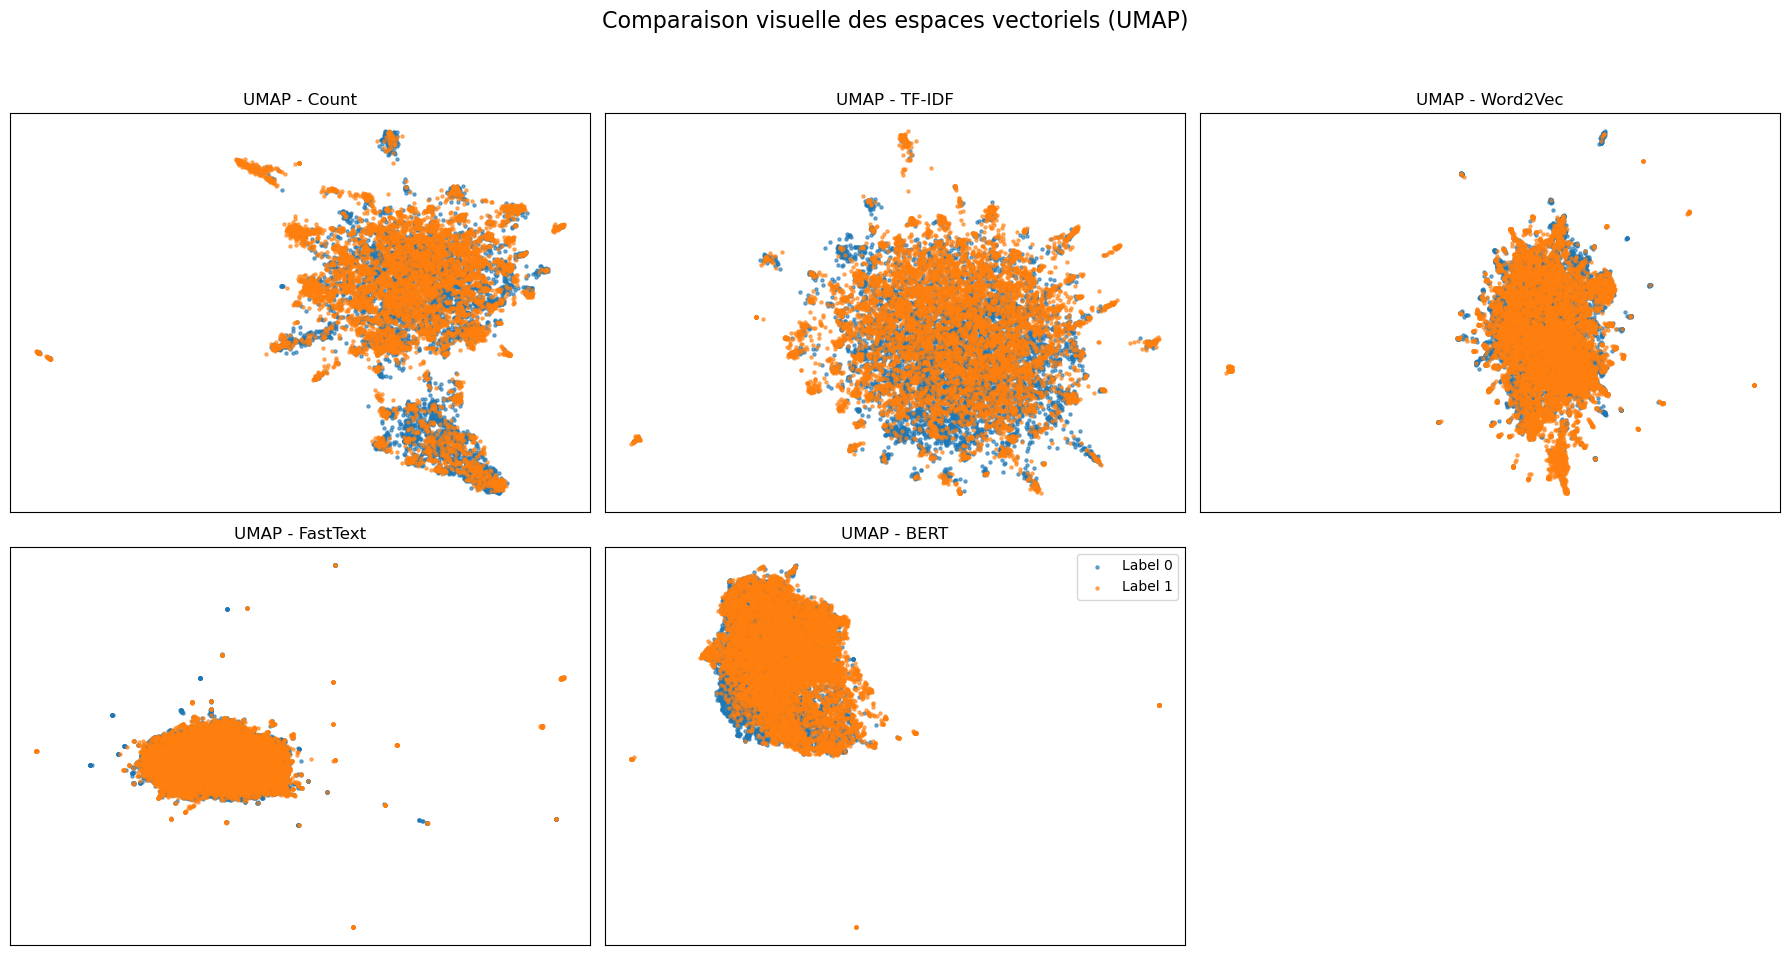

In [45]:
# 4.5.2 Comparaison visuelle de performance des embeddings avec UMAP
import umap.umap_ as umap

# Labels
y = df["label"].values

# Config UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)

# Dictionnaire des matrices à projeter
embedding_dict = {
    "Count": X_count,
    "TF-IDF": X_tfidf,
    "Word2Vec": X_w2v,
    "FastText": X_ft,
    "BERT": X_bert,
}

# Labels (0 = négatif, 4 = positif → on mappe vers 0/1)
y = df["label"].map({0: 0, 4: 1}).values
palette = ["#1f77b4", "#ff7f0e"]  # Bleu / Orange

# Affichage
plt.figure(figsize=(18, 10))

for i, (name, X) in enumerate(embedding_dict.items(), 1):
    X_umap = reducer.fit_transform(X)
    plt.subplot(2, 3, i)
    for label_val in [0, 1]:
        plt.scatter(
            X_umap[y == label_val, 0],
            X_umap[y == label_val, 1],
            c=palette[label_val],
            label=f"Label {label_val}",
            s=5,
            alpha=0.6
        )
    plt.title(f"UMAP - {name}")
    plt.xticks([]); plt.yticks([])

plt.suptitle("Comparaison visuelle des espaces vectoriels (UMAP)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.legend(loc='upper right')
plt.show()


__Observations UMAP :__
- Les embeddings classiques (`count`, `tf-idf`) présentent peu de séparation nette.
- _`Word2Vec`_ et _`FastText`_ montrent des regroupements, mais avec un fort recouvrement.
- _`BERT`_ offre la structure la plus compacte et cohérente visuellement, sans séparation parfaite, mais mieux adaptée à la suite (modélisation supervisée).



---

## __ETAPE 5 : BASELINES SUPERVISEES CLASSIQUES__

---


__Objectifs__
- Tester 3 modèles simples : `LogisticRegression`, `LinearSVC`, `NaiveBayes`
- Utiliser les 16k tweets annotés
- Évaluer les performances via validation croisée
- Comparer les résultats selon le type d’embedding utilisé
- Créer une baseline robuste avant d’aller plus loin

__Les métriques à considérer ici__ : 

Il ne suffit pas de regarder l'accuracy pour savoir si un modèle est bon.  
Il faut choisir la bonne métrique en fonction de :
- La tâche (ici : "analyse de sentiment binaire")
- Le jeu de données (équilibré ou pas ?)
- Le risque métier (faux positifs vs faux négatifs ?)  

Le jeu de données est équilibré ici (8000 / 8000), donc on peut se permettre d’envisager plusieurs scores :

| Métrique                         | Pourquoi l’utiliser dans ce projet                        |
| -------------------------------- | --------------------------------------------------------- |
| __Accuracy__                     | Simple, mais pas toujours pertinent si classe majoritaire |
| __F1-score__                     | Combine _précision_ + _rappel_ → recommandé ici           |
| __Precision__                    | Si on veut éviter les faux positifs                       |
| __Recall__                       | Si on veut éviter les faux négatifs                       |
| __Courbe PR (Precision-Recall)__ | Pour voir le trade-off entre recall et précision          |
| __ROC AUC__ (optionnel)          | Moins utile ici car dataset équilibré                     |

__Décisions__  
Comme  l'objectif repose sur une bonne baseline supervisée, et que notre dataset est bien équilibré :
- Utilisons comme score principal : `f1-score macro` (ou moyenne pondérée si déséquilibre plus tard)
- En plus : regardons `precision`, `recall` et `accuracy`
- Et en bonus : visualisons la courbe `Precision-Recall` pour aller plus loin.  

Tous les modèles n’ont pas été testés sur tous les embeddings, car certains ne sont pas adaptés aux représentations denses (Naive Bayes), ou seraient redondants. Nous avons privilégié la lisibilité et la représentativité des comparaisons.

| Modèle             | Embeddings testés                    | Pourquoi                                             |
| ------------------ | ------------------------------------ | ---------------------------------------------------- |
| LogisticRegression | Count, TF-IDF, W2V, FastText, BERT   | __Modèle de référence__ très adapté aux comparaisons |
| LinearSVC          | TF-IDF, FastText, BERT                | Moins sensible à sparsité                            |
| NaiveBayes         | Count, TF-IDF                        | __Uniquement sparse__                                |



### 5.1 __CREATION DE FONCTIONS POUR AUTOMATISER__

1. `evaluate_model_cv`(model, X, y, model_name, embedding_name, cv=5)  
Effectue la cross-validation et retourne les scores (`accuracy`, `precision`, `recall`, `f1_macro`)
2. `plot_precision_recall_curve_cv(`model, X, y, model_name, embedding_name, cv=5)  
Affiche la `courbe PR moyenne` à partir des folds
3. `log_results`(model_name, embedding_name, scores)  
Logge tout dans `MLflow`

In [46]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

def evaluate_model_cv(model, X_train, y_train):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1s, precisions, recalls, accuracies = [], [], [], []
    y_valid_pred = np.zeros_like(y_train)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        y_valid_pred[val_idx] = y_pred
        f1s.append(f1_score(y_val, y_pred, average="macro"))
        precisions.append(precision_score(y_val, y_pred, average="macro"))
        recalls.append(recall_score(y_val, y_pred, average="macro"))
        accuracies.append(accuracy_score(y_val, y_pred))

    scores = {
        "f1": np.mean(f1s),
        "precision": np.mean(precisions),
        "recall": np.mean(recalls),
        "accuracy": np.mean(accuracies),
    }

    return scores, y_valid_pred



In [47]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve_cv(y_true, y_pred, title="Courbe Précision-Rappel"):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=4)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label="PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.show()



In [53]:
def log_results(model_name, embedding_name, scores):
    """
    Log les résultats d’un modèle dans MLflow.
    """
    
    if mlflow.active_run():
        mlflow.end_run()
        
    mlflow.set_tracking_uri("file:../mlruns")
    mlflow.set_experiment("Projet7-Sentiment")
    
    run_name = f"{model_name}_{embedding_name}"

    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("model", model_name)
        mlflow.log_param("embedding", embedding_name)

        for metric, value in scores.items():
            mlflow.log_metric(metric, value)

    print(f"Résultats loggés dans MLflow ({run_name})")



__Bloc de données commun__  
Le bloc ci-dessous charge le DataFrame nettoyé et le vecteur cible (`y`) unique utilisé pour l’ensemble des modèles supervisés classiques de cette étape.

_Partis pris :_  
- Tous les modèles classiques (LogisticRegression, LinearSVC, NaiveBayes) sont entraînés sur un seul dataset de référence : `tweets_16k_clean_lem`.
- Ce dataset a été nettoyé, lemmatisé, et __les emojis ont été désactivés__ pour une vectorisation textuelle plus classique.
- Cela permet de comparer proprement les performances des modèles entre eux et entre embeddings (`Count`, `TF-IDF`, etc.).
- Pour des modèles plus avancés (ex. : fine-tuning BERT), nous pourrons explorer d’autres jeux de données (avec emojis, ou bruts).

_Ce bloc n’est exécuté qu’une fois en haut du notebook, puis réutilisé dans chaque bloc d’expérimentation._


In [49]:
df = pd.read_parquet(os.path.join(project_root, "data", "processed", "tweets_16k_clean_lem.parquet"))

# Cible pour la modélisation
y = df["label"]

# Vérification
print("__Shape dataset :", df.shape)
print("__Label counts :\n", df["label"].value_counts())

__Shape dataset : (15982, 2)
__Label counts :
 label
0    7991
4    7991
Name: count, dtype: int64


### 5.2 __COUNTVECTORIZER__

#### 5.2.1 __SPLIT STRATIFIE__

Nous avons divisé le jeu de données de 16 000 tweets en :
- _80% pour l’entraînement_ (12 800 tweets)
- _20% pour le test final_ (3 200 tweets)

Le split est __stratifié__, c’est-à-dire que la distribution des labels (`0`, `4`) est conservée dans les deux ensembles.  
Cela garantit une bonne représentativité pour l’évaluation finale.

In [50]:
# Split stratifié (80% / 20%) → Train / Test
from sklearn.model_selection import train_test_split

# Séparation features / target
X = np.load(os.path.join(project_root, "data", "processed", "embeddings", "X_count.npy"))

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Reset index pour éviter les erreurs
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (12785, 13951)
Test shape : (3197, 13951)


#### 5.2.2 __LOGISTIC REGRESSION__

F1         : 0.7307
PRECISION  : 0.7313
RECALL     : 0.7309
ACCURACY   : 0.7309


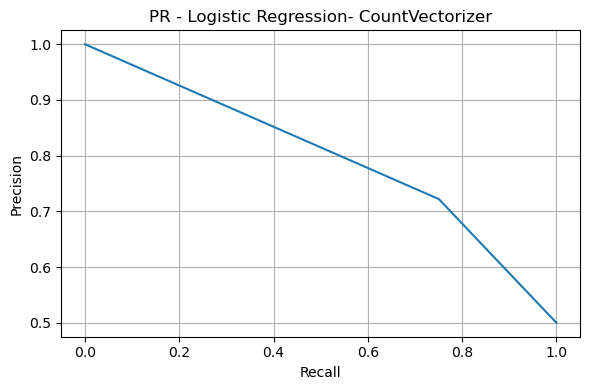

In [51]:
# 5.2.1 Logistic Regression avec CountVectorizer

from sklearn.linear_model import LogisticRegression

# Instanciation du modèle
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Evaluation CV
scores_logreg, y_valid_pred_logreg = evaluate_model_cv(logreg, X_train, y_train.to_numpy())

# Affichage des scores
for metric, value in scores_logreg.items():
    print(f"{metric.upper():<10} : {value:.4f}")

# Courbe PR
plot_precision_recall_curve_cv(y_train, y_valid_pred_logreg, title="PR - Logistic Regression- CountVectorizer")



__Modèle : LogisticRegression__  
__Embedding : CountVectorizer__

- _F1-score_ : __0.7307__
- _Precision_ : 0.7313
- _Recall_ : 0.7309
- _Accuracy_ : 0.7309

La courbe __Precision-Recall__ montre un bon équilibre entre rappel et précision, avec une pente régulière.  
Cela valide `CountVectorizer` comme base raisonnable pour une première modélisation simple.


In [54]:
log_results("Logistic Regression", "count", scores_logreg)


Résultats loggés dans MLflow (Logistic Regression_count)


#### 5.2.3 __NAIVE BAYES__

F1        : 0.7261
PRECISION : 0.7273
RECALL    : 0.7264
ACCURACY  : 0.7264


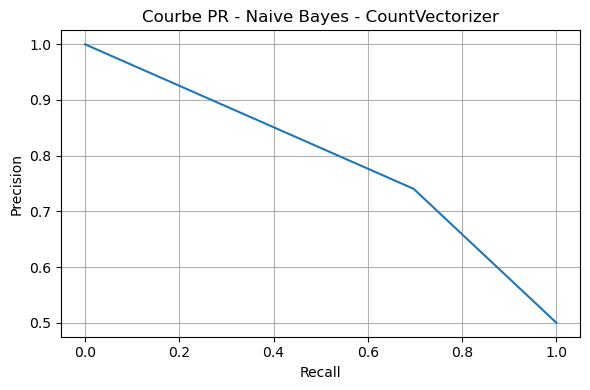

Résultats loggés dans MLflow (Naive Bayes_count)


In [55]:
from sklearn.naive_bayes import MultinomialNB

# Initialisation du modèle
nb = MultinomialNB()

# Évaluation + prédictions via validation croisée
scores_nb, y_valid_pred_nb = evaluate_model_cv(nb, X_train, y_train.to_numpy())

# Affichage structuré des métriques
for metric, value in scores_nb.items():
    print(f"{metric.upper():<10}: {round(value, 4)}")

# Courbe précision-rappel
plot_precision_recall_curve_cv(y_train, y_valid_pred_nb, title="Courbe PR - Naive Bayes - CountVectorizer")

# Log des résultats dans tableau comparatif
log_results("Naive Bayes", "count", scores_nb)


#### 5.2.4 __COMPARATIF DES MODELES SUPERVISES CLASSIQUES AVEC COUNTVECTORIZER__

| Modèle              | F1-score | Precision | Recall | Accuracy |
|---------------------|----------|-----------|--------|----------|
| LogisticRegression  | `0.7307` | `0.7313`  | `0.7309` | `0.7309` |
| NaiveBayes          | `0.7261` | `0.7273`  | `0.7264` | `0.7264` |


### 5.3 __TF-IDF__

#### 5.3.1 __SPLIT STRATIFIE__

⚠️ Le split est relancé pour chaque embedding car les `X` changent de format (sparse ou dense).


In [56]:
# Split stratifié pour TF-IDF

# Chargement des embeddings TF-IDF
X = np.load(os.path.join(project_root, "data", "processed", "embeddings", "X_tfidf.npy"))

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Reset index pour éviter les erreurs
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("__X_train :", X_train.shape)
print("__X_test  :", X_test.shape)

__X_train : (12785, 13951)
__X_test  : (3197, 13951)


#### 5.3.2 __LANCEMENT DES 3 MODELES CLASSIQUES SUR TF-IDF__

__LOGISTIC REGRESSION__


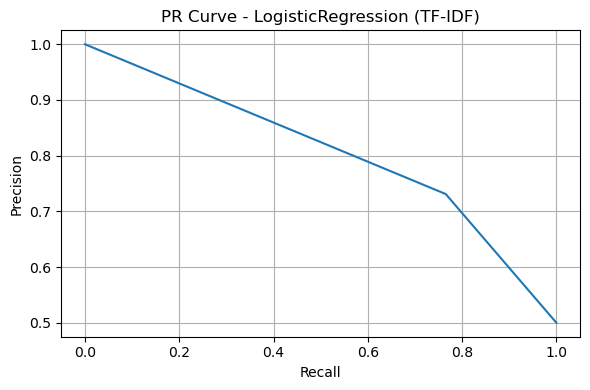

Résultats loggés dans MLflow (Logistic Regression_tfidf)
F1        : 0.7417
PRECISION : 0.7426
RECALL    : 0.7419
ACCURACY  : 0.7419

__LINEAR SVC__


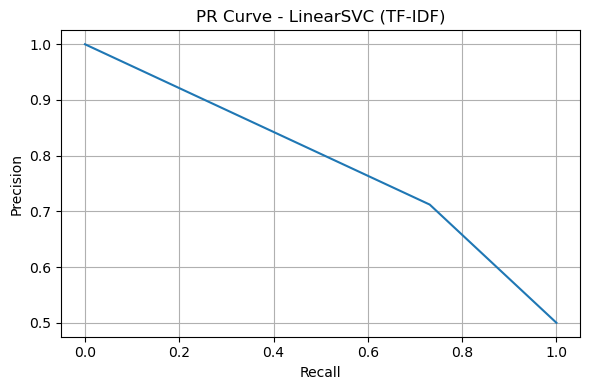

Résultats loggés dans MLflow (LinearSVC_tfidf)
F1        : 0.7178
PRECISION : 0.7181
RECALL    : 0.7179
ACCURACY  : 0.7179

__NAIVE BAYES__


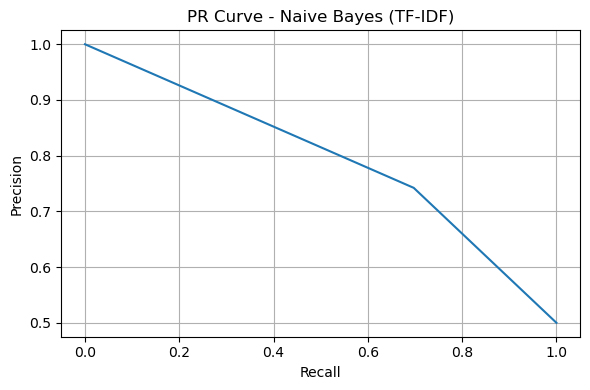

Résultats loggés dans MLflow (Naive Bayes_tfidf)
F1        : 0.7273
PRECISION : 0.7285
RECALL    : 0.7276
ACCURACY  : 0.7276


In [57]:
from sklearn.svm import LinearSVC

print("__LOGISTIC REGRESSION__")
logreg = LogisticRegression(max_iter=1000, random_state=42)
scores_logreg_tfidf, y_valid_pred_logreg_tfidf = evaluate_model_cv(logreg, X_train, y_train.to_numpy())
plot_precision_recall_curve_cv(y_train.to_numpy(), y_valid_pred_logreg_tfidf, title="PR Curve - LogisticRegression (TF-IDF)")
log_results("Logistic Regression", "tfidf", scores_logreg_tfidf)

print(f"F1        : {scores_logreg_tfidf['f1']:.4f}")
print(f"PRECISION : {scores_logreg_tfidf['precision']:.4f}")
print(f"RECALL    : {scores_logreg_tfidf['recall']:.4f}")
print(f"ACCURACY  : {scores_logreg_tfidf['accuracy']:.4f}")

print("\n__LINEAR SVC__")
svc = LinearSVC(max_iter=10000, random_state=42)
scores_svc_tfidf, y_valid_pred_svc_tfidf = evaluate_model_cv(svc, X_train, y_train.to_numpy())
plot_precision_recall_curve_cv(y_train.to_numpy(), y_valid_pred_svc_tfidf, title="PR Curve - LinearSVC (TF-IDF)")
log_results("LinearSVC", "tfidf", scores_svc_tfidf)

print(f"F1        : {scores_svc_tfidf['f1']:.4f}")
print(f"PRECISION : {scores_svc_tfidf['precision']:.4f}")
print(f"RECALL    : {scores_svc_tfidf['recall']:.4f}")
print(f"ACCURACY  : {scores_svc_tfidf['accuracy']:.4f}")

print("\n__NAIVE BAYES__")
nb = MultinomialNB()
scores_nb_tfidf, y_valid_pred_nb_tfidf = evaluate_model_cv(nb, X_train, y_train.to_numpy())
plot_precision_recall_curve_cv(y_train.to_numpy(), y_valid_pred_nb_tfidf, title="PR Curve - Naive Bayes (TF-IDF)")
log_results("Naive Bayes", "tfidf", scores_nb_tfidf)

print(f"F1        : {scores_nb_tfidf['f1']:.4f}")
print(f"PRECISION : {scores_nb_tfidf['precision']:.4f}")
print(f"RECALL    : {scores_nb_tfidf['recall']:.4f}")
print(f"ACCURACY  : {scores_nb_tfidf['accuracy']:.4f}")


#### 5.3.3 __MODELES SUPERVISES SUR TF-IDF__

Les performances ci-dessous ont été obtenues via validation croisée sur 80% des 16k tweets nettoyés et lemmatisés.  
L’objectif ici est de comparer des modèles simples sur une représentation vectorielle sparse (`TF-IDF`), afin d’établir une première baseline.

| Modèle             | F1-score | Precision | Recall | Accuracy |
|--------------------|----------|-----------|--------|----------|
| LogisticRegression | __0.7417__ | 0.7426    | 0.7419 | 0.7419   |
| LinearSVC          | 0.7178   | 0.7181    | 0.7179 | 0.7179   |
| NaiveBayes         | 0.7273   | 0.7285    | 0.7276 | 0.7276   |

__Commentaires :__  
- Le modèle `LogisticRegression` donne les meilleurs résultats sur l'embedding TF-IDF.  
- `NaiveBayes` s’en sort presque aussi bien, malgré sa simplicité.  
- `LinearSVC` semble légèrement en retrait ici, mais pourrait être plus performant avec d'autres embeddings (notamment denses).


### 5.4 __WORD2VEC__

In [58]:
# Split stratifié pour Word2Vec

# Chargement des embeddings Word2Vec
X = np.load(os.path.join(project_root, "data", "processed", "embeddings", "X_w2v.npy"))

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Reset index pour éviter les erreurs dans les fonctions
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Vérification des shapes
print("__X_train :", X_train.shape)
print("__X_test  :", X_test.shape)


__X_train : (12785, 300)
__X_test  : (3197, 300)


__Modèle : Logistic Regression (Word2Vec)__
F1        : 0.73
PRECISION : 0.7301
RECALL    : 0.73
ACCURACY  : 0.73


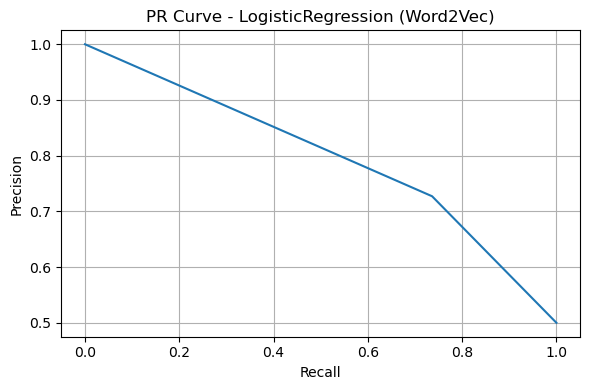

Résultats loggés dans MLflow (Logistic Regression_w2v)


In [59]:
# Logistic Regression sur Word2Vec
print("__Modèle : Logistic Regression (Word2Vec)__")

# Modèle
logreg_w2v = LogisticRegression(max_iter=1000, random_state=42)

# Entraînement + évaluation
scores_logreg_w2v, y_valid_pred_logreg_w2v = evaluate_model_cv(logreg_w2v, X_train, y_train.to_numpy())

# Affichage des scores
print("F1        :", round(scores_logreg_w2v["f1"], 4))
print("PRECISION :", round(scores_logreg_w2v["precision"], 4))
print("RECALL    :", round(scores_logreg_w2v["recall"], 4))
print("ACCURACY  :", round(scores_logreg_w2v["accuracy"], 4))

# Courbe PR
plot_precision_recall_curve_cv(y_train, y_valid_pred_logreg_w2v, title="PR Curve - LogisticRegression (Word2Vec)")

# Log dans MLflow
log_results("Logistic Regression", "w2v", scores_logreg_w2v)


__Analyse des résultats - Logistic Regression avec Word2Vec__

- Le score F1 obtenu est de __0.73__, très proche des résultats obtenus avec CountVectorizer (__0.7307__) et TF-IDF (__0.7417__).
- Cela confirme que l’embedding Word2Vec (pré-entraîné Google News) est efficace, __même sans contexte spécifique__, sur des tweets déjà nettoyés.
- La densité de l’espace vectoriel (sparsity = 0.0129) n’a pas gêné la régression logistique.
- On observe néanmoins __aucun gain significatif par rapport aux approches classiques__ de type TF-IDF ou Count.

__Conclusion__  
→ Word2Vec ne surperforme pas ici, mais fournit une base dense exploitable.  
→ Nous pouvons maintenant comparer avec un embedding plus robuste sur du texte bruité : __FastText__.


### 5.5 __FASTTEXT__

In [60]:
# Split stratifié - Embedding FastText

# Chargement des embeddings FastText
X = np.load(os.path.join(project_root, "data", "processed", "embeddings", "X_ft.npy"))

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Reset index
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Vérification
print("__X_train :", X_train.shape)
print("__X_test  :", X_test.shape)


__X_train : (12785, 300)
__X_test  : (3197, 300)


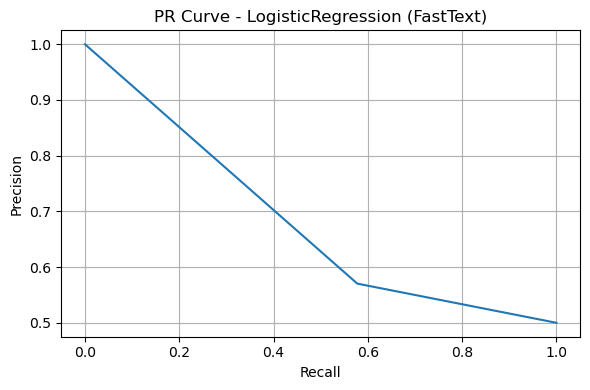

Résultats loggés dans MLflow (Logistic Regression_fasttext)
__Modèle : Logistic Regression (FastText)__
F1         : 0.5710
PRECISION  : 0.5713
RECALL     : 0.5712
ACCURACY   : 0.5712


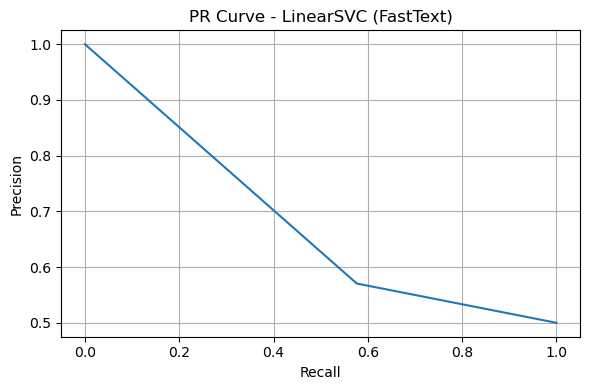

Résultats loggés dans MLflow (LinearSVC_fasttext)

__Modèle : Linear SVC (FastText)__
F1         : 0.5711
PRECISION  : 0.5713
RECALL     : 0.5712
ACCURACY   : 0.5712


In [61]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
scores_logreg_ft, y_valid_pred_logreg_ft = evaluate_model_cv(logreg, X_train, y_train.to_numpy())
plot_precision_recall_curve_cv(y_train, y_valid_pred_logreg_ft, title="PR Curve - LogisticRegression (FastText)")
log_results("Logistic Regression", "fasttext", scores_logreg_ft)

print("__Modèle : Logistic Regression (FastText)__")
for k, v in scores_logreg_ft.items():
    print(f"{k.upper():<10} : {v:.4f}")

# Linear SVC
svc = LinearSVC(max_iter=10000, random_state=42)
scores_svc_ft, y_valid_pred_svc_ft = evaluate_model_cv(svc, X_train, y_train.to_numpy())
plot_precision_recall_curve_cv(y_train, y_valid_pred_svc_ft, title="PR Curve - LinearSVC (FastText)")
log_results("LinearSVC", "fasttext", scores_svc_ft)

print("\n__Modèle : Linear SVC (FastText)__")
for k, v in scores_svc_ft.items():
    print(f"{k.upper():<10} : {v:.4f}")


#### __RESULTATS FASTTEXT__

Embedding dense pré-entraîné basé sur les sous-mots (FastText).  
Performances nettement inférieures aux autres embeddings sur ce jeu de données.

| Modèle           | F1-score | Precision | Recall | Accuracy |
|------------------|----------|-----------|--------|----------|
| LogisticRegression | 0.5710   | 0.5713    | 0.5712 | 0.5712   |
| LinearSVC          | 0.5711   | 0.5713    | 0.5712 | 0.5712   |


### 5.5 __BERT__

In [62]:
# 1. Chargement des labels depuis le dataset adapté à BERT
df = pd.read_parquet(os.path.join(project_root, "data", "processed", "tweets_16k_raw.parquet"))
y = df["label"]

# 2. Chargement des embeddings BERT
X = np.load(os.path.join(project_root, "data", "processed", "embeddings", "X_bert.npy"))

# 3. Split stratifié
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 4. Reset index (sécurité)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("__X_train :", X_train.shape)
print("__X_test  :", X_test.shape)


__X_train : (12785, 768)
__X_test  : (3197, 768)


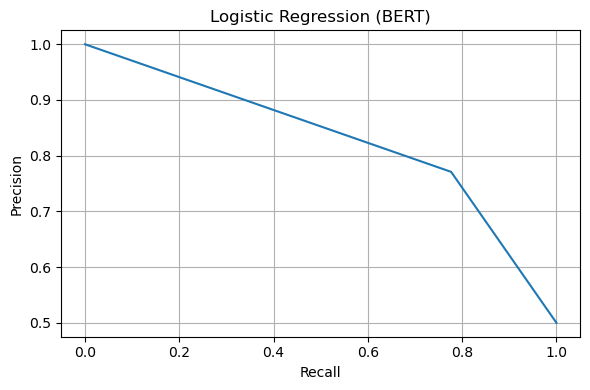

Résultats loggés dans MLflow (Logistic Regression_bert)
__Modèle : Logistic Regression (BERT)__
F1        : 0.7729
PRECISION : 0.7731
RECALL    : 0.7729
ACCURACY  : 0.7729


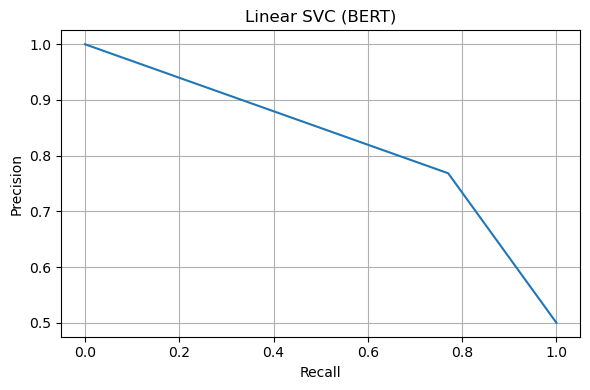

Résultats loggés dans MLflow (LinearSVC_bert)

__Modèle : Linear SVC (BERT)__
F1        : 0.7691
PRECISION : 0.7693
RECALL    : 0.7691
ACCURACY  : 0.7691


In [63]:
# 1. Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
scores_logreg_bert, y_valid_pred_logreg_bert = evaluate_model_cv(logreg, X_train, y_train.to_numpy())
plot_precision_recall_curve_cv(y_train.to_numpy(), y_valid_pred_logreg_bert, title="Logistic Regression (BERT)")
log_results("Logistic Regression", "bert", scores_logreg_bert)

print("__Modèle : Logistic Regression (BERT)__")
for metric, value in scores_logreg_bert.items():
    print(f"{metric.upper():<10}: {value:.4f}")

# 2. Linear SVC
svc = LinearSVC(max_iter=10000, random_state=42)
scores_svc_bert, y_valid_pred_svc_bert = evaluate_model_cv(svc, X_train, y_train.to_numpy())
plot_precision_recall_curve_cv(y_train.to_numpy(), y_valid_pred_svc_bert, title="Linear SVC (BERT)")
log_results("LinearSVC", "bert", scores_svc_bert)

print("\n__Modèle : Linear SVC (BERT)__")
for metric, value in scores_svc_bert.items():
    print(f"{metric.upper():<10}: {value:.4f}")


__Modélisation classique avec BERT__

Dans cette section, nous avons évalué les performances de deux modèles supervisés simples (`Logistic Regression` et `Linear SVC`) sur les représentations vectorielles générées par BERT (`bert-base-uncased`).  
Les tweets utilisés proviennent du fichier `tweets_16k_raw.parquet` : ils sont bruts, sans lemmatisation ni stemming.

| Modèle              | F1-score | Precision | Recall | Accuracy |
|---------------------|----------|-----------|--------|----------|
| __LogisticRegression__ | 0.7729   | 0.7731    | 0.7729 | 0.7729   |
| __LinearSVC__          | 0.7691   | 0.7693    | 0.7691 | 0.7691   |


### 5.6 __SYNTHESE DES MODELES DE BASE__

| Modèle              | Embedding     | F1-score | Précision | Recall  | Accuracy |
|---------------------|---------------|----------|-----------|---------|----------|
| LogisticRegression  | Count         | 0.7307   | 0.7313    | 0.7309  | 0.7309   |
| NaiveBayes          | Count         | 0.7261   | 0.7273    | 0.7264  | 0.7264   |
| LogisticRegression  | TF-IDF        | 0.7417   | 0.7426    | 0.7419  | 0.7419   |  
| LinearSVC           | TF-IDF        | 0.7178   | 0.7181    | 0.7179  | 0.7179   |
| NaiveBayes          | TF-IDF        | 0.7273   | 0.7285    | 0.7276  | 0.7276   |
| LogisticRegression  | Word2Vec      | 0.73     | 0.7301    | 0.73    | 0.73     |
| LogisticRegression  | FastText      | 0.5710   | 0.5713    | 0.5712  | 0.5712   |
| LinearSVC           | FastText      | 0.5711   | 0.5713    | 0.5712  | 0.5712   |
| LogisticRegression  | BERT          | 0.7729   | 0.7731    | 0.7729  | 0.7729   |
| LinearSVC           | BERT          | 0.7691   | 0.7693    | 0.7691  | 0.7691   |

__Observations__ :
- Les meilleures performances sont obtenues avec les embeddings BERT.
- Les modèles simples (`LogisticRegression`) performent souvent mieux que `LinearSVC` et `NaiveBayes`, sauf sur TF-IDF où la différence est moindre.
- FastText montre des résultats nettement inférieurs sur cette tâche, sans doute à cause de la perte de sémantique spécifique au contexte.
